In [1]:
# !pip install scipy
# !pip install ruptures

# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from fluss import *
from evaluation import *


# Dataset loading

In [67]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

#df = load_dataset_to_dataframe(filepath)


# these function allows to load dataset from .arff file, each function is designed for diffrent represenation
def stack_time_series_randomly(df, opt, seed, block_size):
    """This function creates new dataframe without segmentation and classification, what is more its rows are randomly shuffled

    Args:
        df: segmented dataframe
        seed: this value is being passed to the sample function which shuffles rows in dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    #print( df.iloc[0,0].shape)
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    
    change_points = np.array([],dtype=int)
    chunk_size = len(df.iloc[0,0][0])

    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    if(opt == True):
        # Krok 1: Podziel dataframe na bloki
        blocks = [df.iloc[i:i + block_size] for i in range(0, len(df), block_size)]
        
        # Krok 2: Wymieszaj kolejność bloków
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(len(blocks))
        shuffled_blocks = [blocks[i] for i in shuffled_indices]
        
        # Krok 3: Połącz bloki z powrotem w jeden dataframe
        df = pd.concat(shuffled_blocks).reset_index(drop=True)
        #df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    # filling it with empty numpy arrays
    #print(dimensionality)
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    last_class = df.iloc[0,1]
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,int(index*chunk_size))
        last_class = row[1]
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked, change_points

# random_stacked, change_points = stack_time_series_randomly(df,True)
# random_stacked = dataframe_to_ndarray(random_stacked)

# plt.plot(random_stacked)
# plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
#print(random_stacked)

def load_data_multivariate_representation(filepath, seed, block_size):
        df = load_dataset_to_dataframe(filepath)
        window_size = len(df.iloc[0,0][0])
        data, original_points = stack_time_series_randomly(df, True, seed, block_size)
        data = dataframe_to_ndarray(data)
        return data, original_points, window_size


def load_data_univariate_representation(filepath, seed, block_size, group, shuffle):
    # Load the dataset into a DataFrame
    df = load_dataset_to_dataframe(filepath)
    #print(df)    
    if group:
       df = df.sort_values(by = df.columns[-1]).reset_index(drop=True)

    if shuffle:
            # Krok 1: Podziel dataframe na bloki
        blocks = [df.iloc[i:i + block_size,:] for i in range(0, len(df), block_size)]
            
            # Krok 2: Wymieszaj kolejność bloków
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(len(blocks))
        shuffled_blocks = [blocks[i] for i in shuffled_indices]
            
            # Krok 3: Połącz bloki z powrotem w jeden dataframe
        df = pd.concat(shuffled_blocks).reset_index(drop=True)    # Initialize the flattened data array and original points list
        
    #print(df)   
    data = np.array([])
    original_points = []
    
    # Calculate the window size
    window_size = len(df.columns) - 1
    
    # Iterate over the DataFrame rows to flatten the data
    last_class = df.iloc[0,-1]
    sum = 0
    for index, row in df.iterrows():
        data = np.concatenate((data, row[:-1].values.flatten())).astype(dtype=float)

        if(row[-1]!=last_class):
            #print(row[-1])
            #print(last_class)
            original_points.append(sum)
        #print(last_class)
        sum += window_size
        last_class = row[-1]
    
    # Convert original_points to numpy array and remove the last element
    original_points = np.array(original_points).astype(dtype=int)
    
    return data, original_points, window_size

def load_df_2d_representation_grouped(filepath):
    df = load_dataset_to_dataframe(filepath)
    original_points = np.array([])
    data = np.array([])
    groups = df.groupby('target')
    window_size = len(df.columns) - 1
    sum = 0 
    for name, group in groups:
        data = np.concatenate((data, group.values[:,:-1].flatten())).astype(dtype=float)
        original_points = np.append(original_points, sum + group.shape[0]*( group.shape[1]-1))
        sum += group.shape[0]*( group.shape[1]-1)
    return data, original_points[:-1].astype(dtype = int), window_size
    



def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    chunk_size = len(df.iloc[0,0][0])
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked


def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()



# Classic Change points Algorithms

In [3]:
def predict_change_points_bottomup(data, n, original_points, cost_function):
    algo = rpt.BottomUp(model=cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)
    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]


def predict_change_points_binseg(data, n, original_points, cost_function):
    algo = rpt.Binseg(model = cost_function)
    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))

    evaluation = get_evaluation(result[:-1], original_points, n )
    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

def predict_change_points_window(data, n, original_points, cost_function, window_size):
    algo = None
    if type(cost_function) == str:
        algo = rpt.Window(width = window_size, model = cost_function)
    else:
        algo = rpt.Window(width = window_size, custom_cost = cost_function)

    algo.fit(data)
    result = algo.predict(n_bkps = len(original_points))
    evaluation = get_evaluation(result[:-1], original_points, n)

    #rpt.display(data, np.append(original_points,result[-1]), result)
    return evaluation, result[:-1]

# Benchmark Class

In [175]:
import plotly.express as px


class SegmenationAlgorithmsBenchmark():
    def __init__(self, experiments_number, algorithms_number, algorithms_tags):
        self.experiments_number = experiments_number
        self.history = []
        self.algorithms_number = algorithms_number
        self.ranksSum = np.zeros(algorithms_number)
        self.experiments_conducted = 0 
        self.algorithms_tags = algorithms_tags

    # def add_experiment(self, results):
    #     if self.experiments_conducted == self.experiments_number:
    #         raise ValueError("Niewłaściwa wartość")
    #     self.experiments_conducted += 1
    #     sorted_indices = np.argsort(results)[::-1] + 1
    #     self.ranksSum += sorted_indices
    #     if self.experiments_conducted == self.experiments_number:
    #         self.print_current_results()

    
    def add_experiment(self, results):
        if self.experiments_conducted == self.experiments_number:
            print("Niewłaściwa wartość")
        else:
            #sorted_indices = np.argsort(results)[::-1] + 1

            order = results.argsort()[::-1]
            sorted_indices = order.argsort()+ 1
            self.ranksSum += sorted_indices
            self.history.append(sorted_indices)
            self.experiments_conducted += 1
            if self.experiments_conducted == self.experiments_number:
                self.print_current_results()       
            
    def print_current_results(self):
        print("Conducted experimets: "+str(self.experiments_conducted))

        # x = []
        # y = []

        # df = pd.DataFrame(self.history)
        # for i, array in enumerate(self.history):
        #     x.extend([i] * len(array))  # Współrzędne x (wszystkie elementy mają taką samą współrzędną x)
        #     y.extend(array)  # Współrzędne y (wartości z tablicy)
        
        # # Tworzenie scatter plot
        # plt.scatter(x, y)
        
        # # Opcjonalne etykiety osi
        # plt.xlabel('Index of array in list')
        # plt.ylabel('Values in arrays')
        
        # Wyświetlenie scatter plot
        plt.show()
        for i in range(self.algorithms_number):
            print(self.algorithms_tags[i]+" current average rank is: "+str((float(self.ranksSum[i])/ self.experiments_conducted)))
                    
# arr = np.array([3,4,16])
# print(np.argsort(arr[::-1]))

        
        

# Randomize dataframe rows

# Benchmark Beginning

In [176]:
Benchmark = SegmenationAlgorithmsBenchmark(10, 4, ["window","binseg","bottomup","fluss"])

# Experiment 1 (RacketSports)

In [4]:
filepath = './datasets/RacketSports/RacketSports_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
window_size = len(df.iloc[0,0][0])

print(df)

racket_ds, change_points = stack_time_series_randomly(df,False)
racket_ds = dataframe_to_ndarray(racket_ds)

outputs = np.array([])

exp1 = np.zeros(Benchmark.algorithms_number)
n = racket_ds.shape[0]

                                         relationalAtt  \
0    [[1.266676, -2.180751, -0.943348, 0.440631, 1....   
1    [[0.464568, 7.017253, 0.401548, 0.401548, -2.8...   
2    [[0.094274, 1.185966, 3.730646, 3.730646, 3.73...   
3    [[-1.23979, -1.2172, -0.215688, 1.553247, 1.44...   
4    [[-0.108107, 4.973278, 1.181158, -1.893015, -1...   
..                                                 ...   
146  [[0.314572, 8.349167, 21.379345, 19.026033, 19...   
147  [[-0.743014, 9.206404, 15.012686, 12.535641, 1...   
148  [[0.918178, 7.336412, 8.367985, 13.632561, 16....   
149  [[2.582684, 13.509926, 13.509926, 12.486249, 1...   
150  [[-2.214484, -0.07487, -1.944632, -1.36206, -1...   

                    activity  
0         b'Badminton_Smash'  
1         b'Badminton_Smash'  
2         b'Badminton_Smash'  
3         b'Badminton_Smash'  
4         b'Badminton_Smash'  
..                       ...  
146  b'Squash_BackhandBoast'  
147  b'Squash_BackhandBoast'  
148  b'Squash_BackhandBo

NameError: name 'stack_time_series_randomly' is not defined

188.75


Metryka     Wartość
0     Acc    0.998824
1    Prec    0.333333
2  Recall    0.333333
3      F1    0.333333
4     ASC    0.333333
5     ASD  150.000000
6     ADT    0.000000

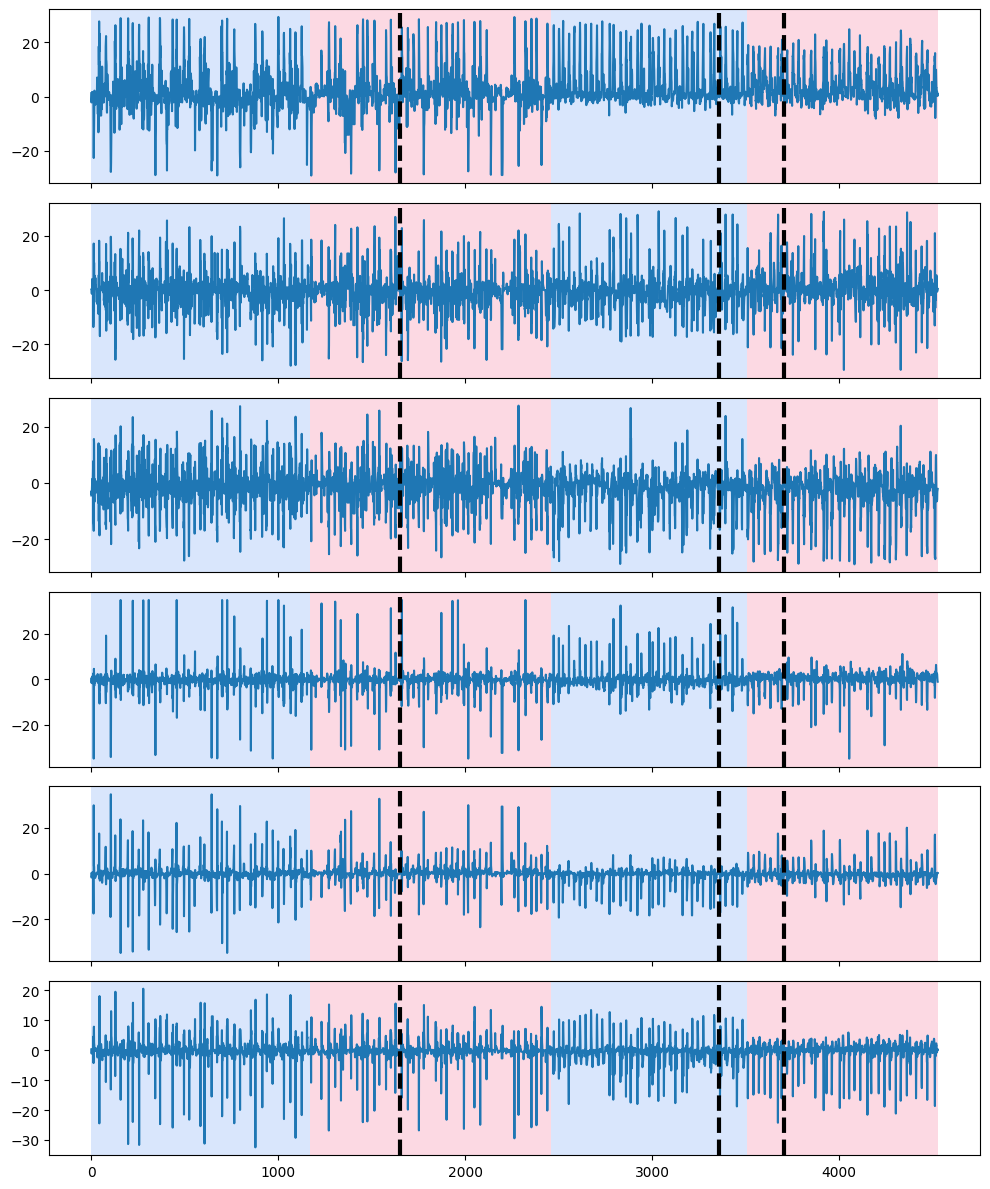

In [178]:
eval, result = predict_change_points_window(racket_ds, n, change_points, "rbf", window_size)
exp1[0] = eval.iloc[3,1]

eval


188.75


Metryka    Wartość
0     Acc   0.999412
1    Prec   0.666667
2  Recall   0.666667
3      F1   0.666667
4     ASC   1.000000
5     ASD  26.666667
6     ADT   1.000000

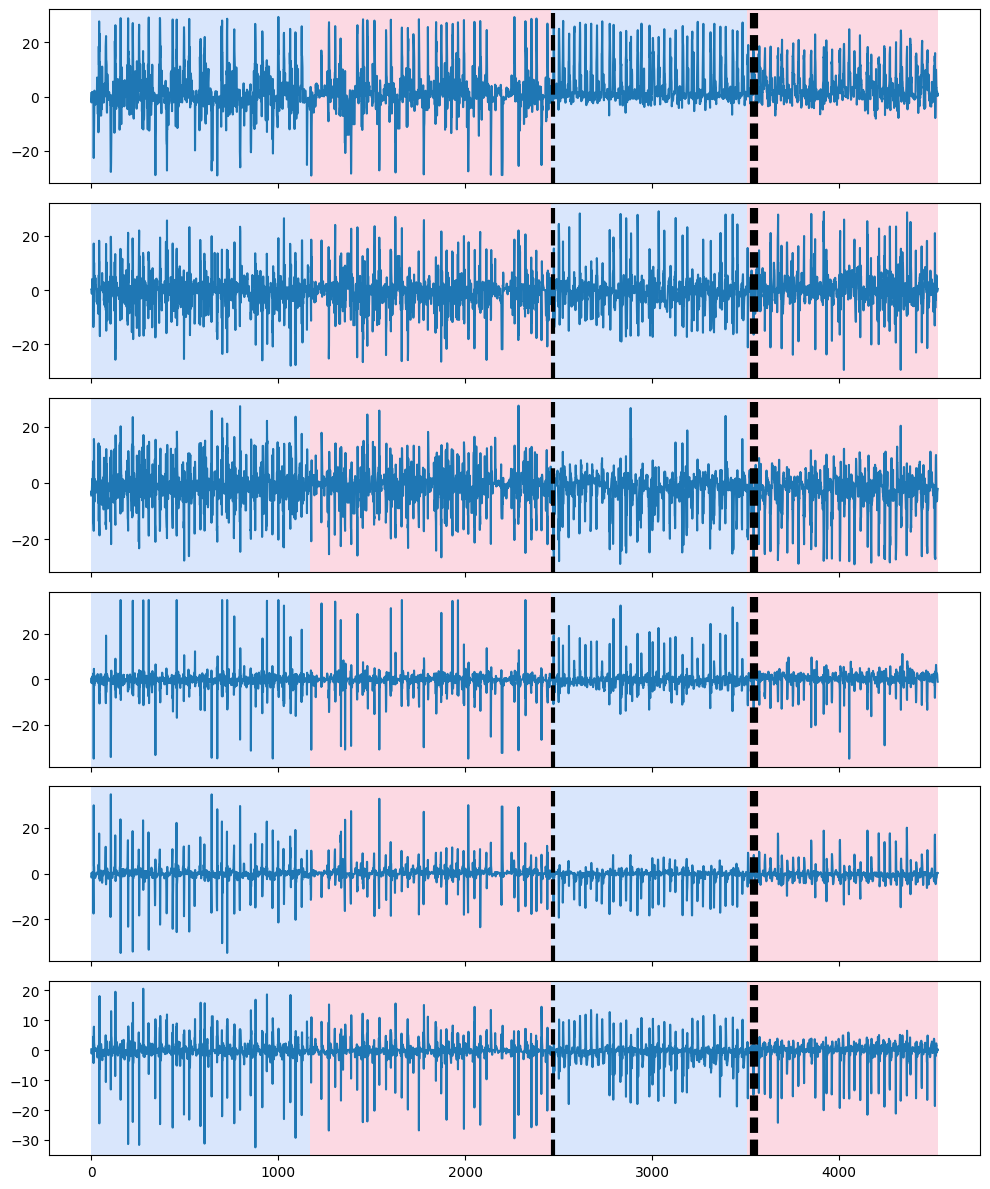

In [179]:
eval, result = predict_change_points_binseg(racket_ds, n, change_points, "l1")
exp1[1] = eval.iloc[3,1]

eval


188.75


Metryka    Wartość
0     Acc   0.999412
1    Prec   0.666667
2  Recall   0.666667
3      F1   0.666667
4     ASC   0.666667
5     ASD  20.000000
6     ADT   0.000000

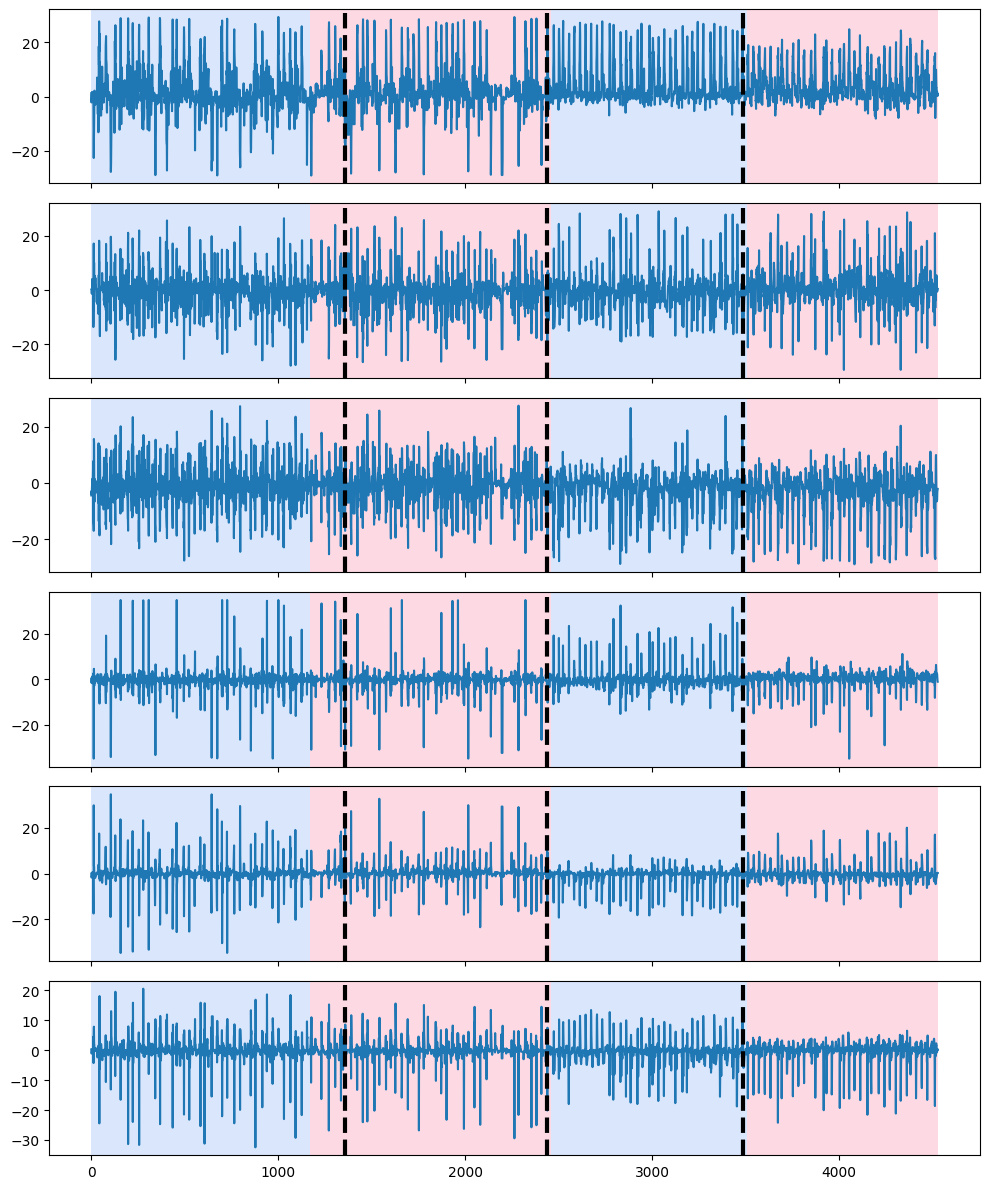

In [180]:
eval, result = predict_change_points_bottomup(racket_ds, n, change_points, "linear")
exp1[2] = eval.iloc[3,1]

eval


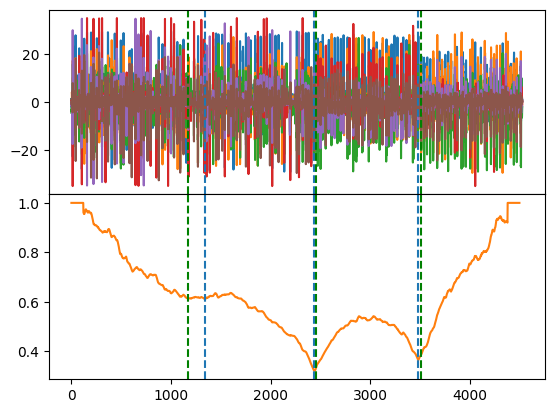

188.75
[0.33333333 0.66666667 0.66666667 1.        ]
Conducted experimets: 1
window current average rank is: 4.0
binseg current average rank is: 3.0
bottomup current average rank is: 2.0
fluss current average rank is: 1.0


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  73.000000
6     ADT   0.333333

In [181]:
FlussRegimeSegmentator = Fluss(window_size, 4)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(racket_ds)
FlussRegimeSegmentator.print_latest_output(change_points)

eval = get_evaluation(regimes,change_points,racket_ds.shape[0])

exp1[3] = eval.iloc[3,1]

print(exp1)

Benchmark.add_experiment(exp1)
Benchmark.print_current_results()
eval

[array([4, 3, 2, 1], dtype=int64)]


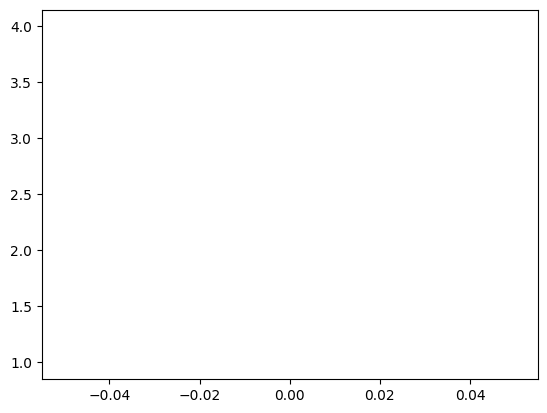

In [182]:
import plotly.express as px

print(Benchmark.history)
plt.plot(Benchmark.history)
plt.show()

# Experiment 2 (Earthquakes)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

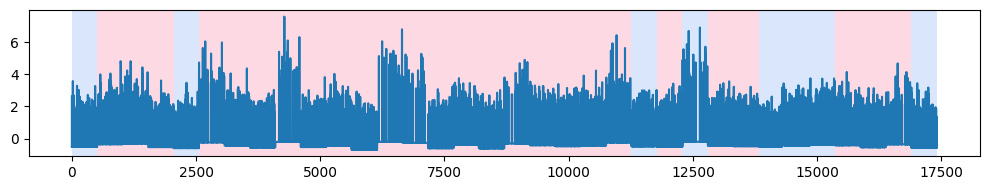

In [183]:
filepath = './datasets/Earthquakes/Earthquakes_TRAIN.arff'
earth_ds, original_points, window_size = load_df_2d_representation(filepath)

x = 10
i = original_points[x]
exp2 = np.zeros(Benchmark.algorithms_number)

rpt.display(earth_ds[:i], original_points[:(x+1)])

217.6


Metryka   Wartość
0     Acc  0.998929
1    Prec  0.300000
2  Recall  0.300000
3      F1  0.300000
4     ASC  0.300000
5     ASD  0.666667
6     ADT  0.333333

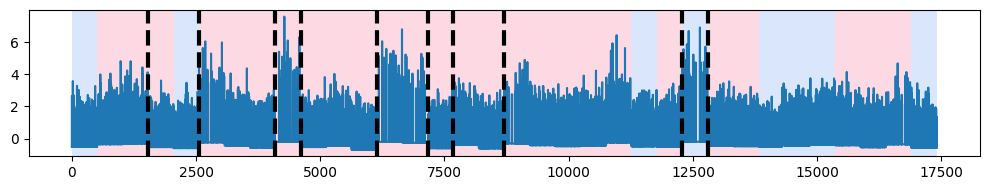

In [184]:
eval, result = predict_change_points_window(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"rank" , window_size)
exp2[0] = eval.iloc[3,1]
eval


217.6


Metryka   Wartość
0     Acc  0.998776
1    Prec  0.200000
2  Recall  0.200000
3      F1  0.200000
4     ASC  0.200000
5     ASD  3.000000
6     ADT  0.500000

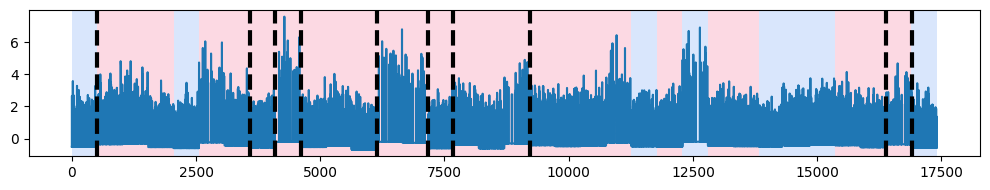

In [185]:
eval, result = predict_change_points_binseg(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"l1" )
exp2[1] = eval.iloc[3,1]
eval


217.6


Metryka   Wartość
0     Acc  0.998929
1    Prec  0.300000
2  Recall  0.300000
3      F1  0.300000
4     ASC  0.300000
5     ASD  0.666667
6     ADT  0.333333

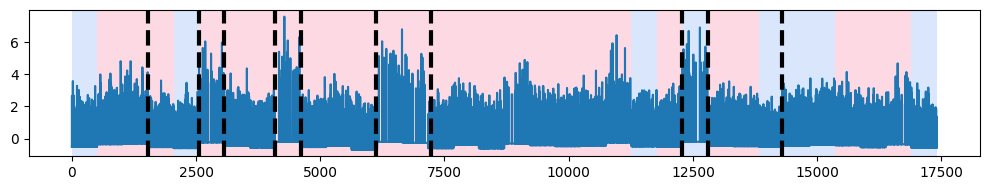

In [186]:
eval, result = predict_change_points_bottomup(earth_ds[:i], earth_ds[:i].shape[0], original_points[:x],"l1" )
exp2[2] = eval.iloc[3,1]
eval


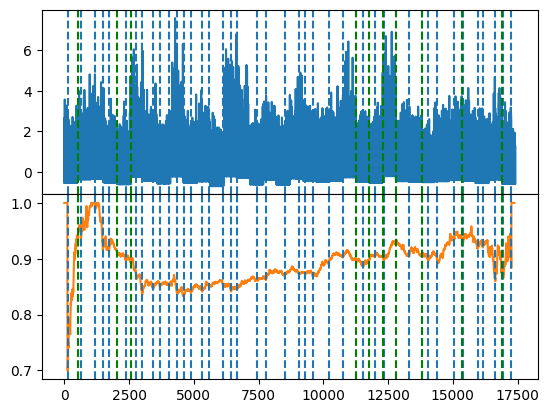

217.6
Conducted experimets: 2
window current average rank is: 3.0
binseg current average rank is: 3.5
bottomup current average rank is: 1.5
fluss current average rank is: 2.0


Metryka    Wartość
0     Acc   0.997169
1    Prec   0.170732
2  Recall   0.700000
3      F1   0.274510
4     ASC   0.700000
5     ASD  93.142857
6     ADT   0.714286

In [187]:
FlussEarth = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(earth_ds[:i])
FlussRegimeSegmentator.print_latest_output(original_points[:x])

eval = get_evaluation(regimes, original_points[:x], earth_ds[:i].shape[0])
exp2[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp2)
Benchmark.print_current_results()
eval

In [188]:
print(Benchmark.history)

# sorted_indices = np.argsort((exp2))
print(exp2)
# print(sorted_indices)


# sorted_indices = np.argsort(exp1)
print(exp1)
# print(sorted_indices)

[array([4, 3, 2, 1], dtype=int64), array([2, 4, 1, 3], dtype=int64)]
[0.3       0.2       0.3       0.2745098]
[0.33333333 0.66666667 0.66666667 1.        ]


# Experiment 3 (UMD)

[1800 3600]


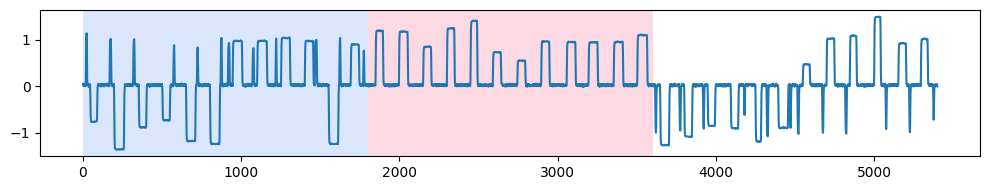

In [189]:
filepath = './datasets/UMD/UMD_TRAIN.arff'

umd_data, original_points, window_size = load_df_2d_representation(filepath)
print(original_points)
rpt.display(umd_data, original_points)

exp3 = np.zeros(Benchmark.algorithms_number)
n = umd_data.shape[0]

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



337.5
[2065, 3500]


Metryka  Wartość
0     Acc      1.0
1    Prec      1.0
2  Recall      1.0
3      F1      1.0
4     ASC      1.0
5     ASD    182.5
6     ADT      0.5

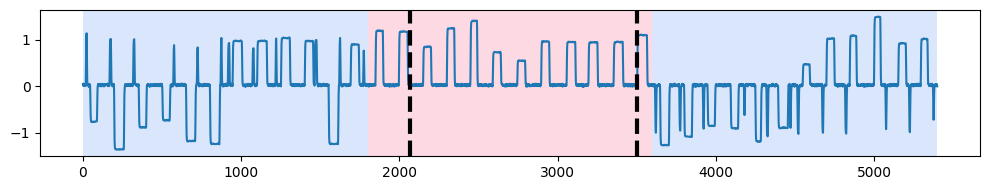

In [190]:
eval, result = predict_change_points_window(umd_data, n, original_points, "normal", window_size)
print(result)
exp3[0] = eval.iloc[3,1]
eval


In [191]:
eval, result = predict_change_points_binseg(umd_data, n, original_points, "normal")
print(result)
exp3[1] = eval.iloc[3,1]
eval


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



337.5
[870, 3570]


Metryka    Wartość
0     Acc   0.999506
1    Prec   0.500000
2  Recall   0.500000
3      F1   0.500000
4     ASC   0.500000
5     ASD  30.000000
6     ADT   0.000000

337.5
[865, 3650]


Metryka    Wartość
0     Acc   0.999506
1    Prec   0.500000
2  Recall   0.500000
3      F1   0.500000
4     ASC   0.500000
5     ASD  50.000000
6     ADT   1.000000

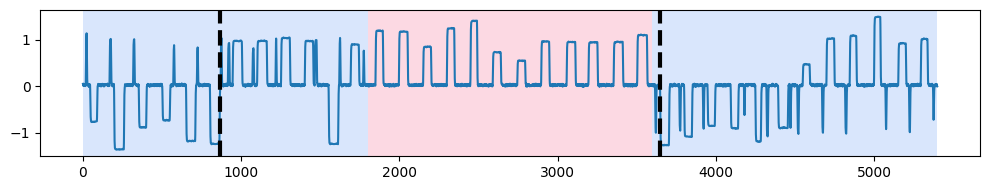

In [192]:
eval, result = predict_change_points_bottomup(umd_data, n, original_points, "l2")
print(result)
exp3[2] = eval.iloc[3,1]
eval


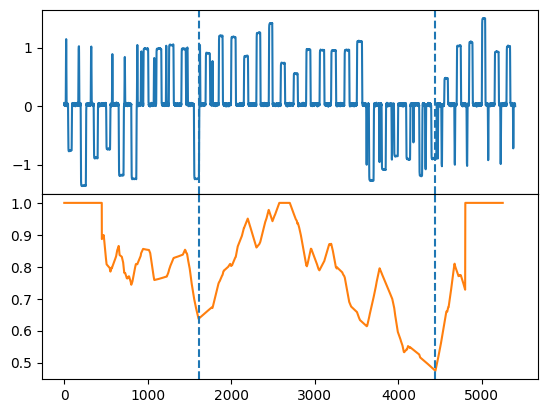

337.5
Conducted experimets: 3
window current average rank is: 2.3333333333333335
binseg current average rank is: 3.6666666666666665
bottomup current average rank is: 2.0
fluss current average rank is: 2.0


Metryka     Wartość
0     Acc    0.999506
1    Prec    0.500000
2  Recall    0.500000
3      F1    0.500000
4     ASC    0.500000
5     ASD  192.000000
6     ADT    0.000000

In [193]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(umd_data)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes, original_points, n)

exp3[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp3)
Benchmark.print_current_results()
eval

# Experiment 4 (FreezerSmallTrain)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

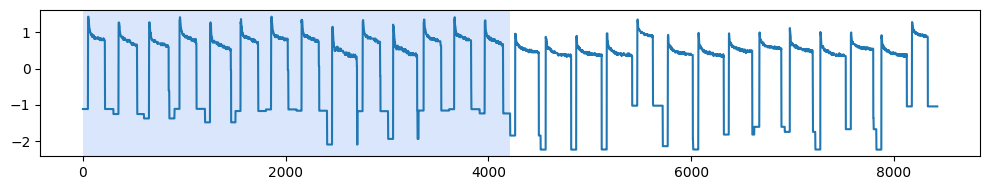

In [194]:
filepath = './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'

fst_ds, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp4 = np.zeros(Benchmark.algorithms_number)
rpt.display(fst_ds, original_points)



In [195]:
eval, result = predict_change_points_window(fst_ds, fst_ds.shape[0], original_points, "l1", window_size)
exp4[0] = eval.iloc[3,1]
eval


1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

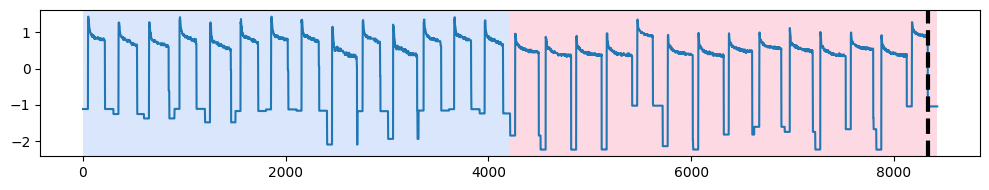

In [196]:
eval, result = predict_change_points_binseg(fst_ds, fst_ds.shape[0], original_points, "l2")
exp4[1] = eval.iloc[3,1]
eval


1053.5


Metryka   Wartość
0     Acc  0.999684
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

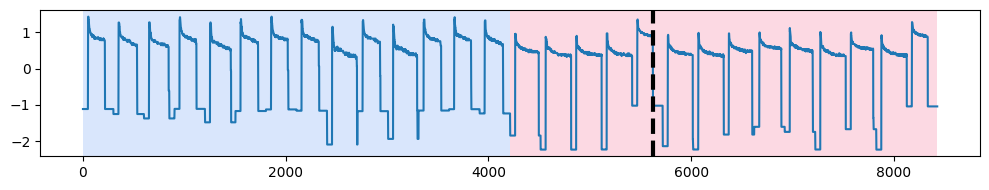

In [197]:
eval, result = predict_change_points_bottomup(fst_ds, fst_ds.shape[0], original_points, "l1")
exp4[2] = eval.iloc[3,1]
eval


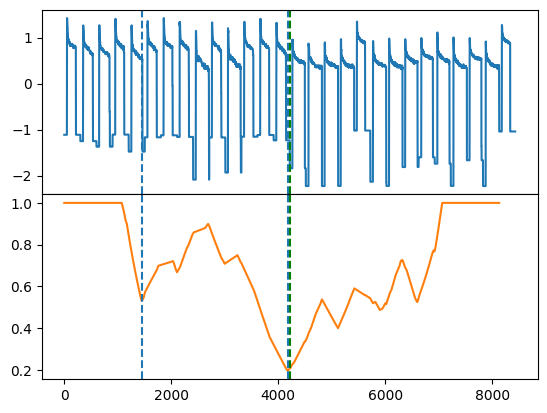

1053.5
Conducted experimets: 4
window current average rank is: 2.75
binseg current average rank is: 3.5
bottomup current average rank is: 2.0
fluss current average rank is: 1.75
[1446 4174]


Metryka    Wartość
0     Acc   0.999842
1    Prec   0.500000
2  Recall   1.000000
3      F1   0.666667
4     ASC   1.000000
5     ASD  40.000000
6     ADT   0.000000

In [198]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(fst_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,fst_ds.shape[0])
exp4[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp4)
Benchmark.print_current_results()
print(regimes)
eval

# Experiment 5 (Libras)

(<Figure size 1000x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

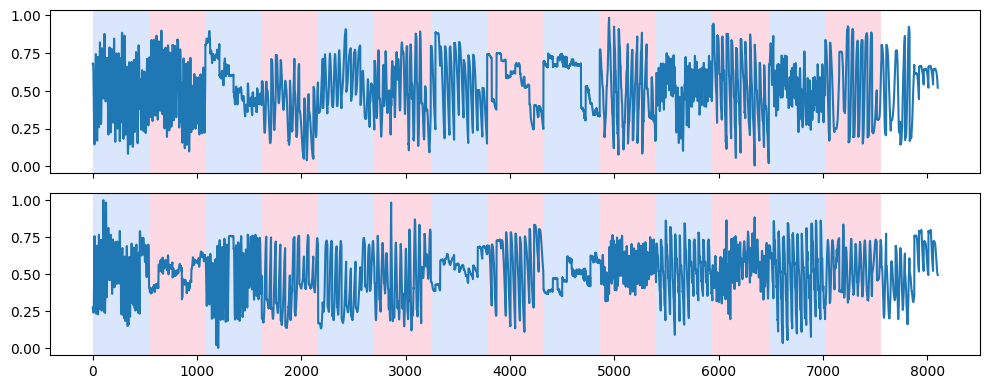

In [199]:
filepath = './datasets/Libras/Libras_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

window_size = len(df.iloc[0,0][0])



libras_ds, original_points  = stack_time_series_randomly(df,False)
libras_ds = dataframe_to_ndarray(libras_ds)

exp5 = np.zeros(Benchmark.algorithms_number)
n = libras_ds.shape[0]
rpt.display(libras_ds, original_points)



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



72.32142857142857


Metryka    Wartość
0     Acc   0.997042
1    Prec   0.357143
2  Recall   0.357143
3      F1   0.357143
4     ASC   0.428571
5     ASD  22.500000
6     ADT   0.333333

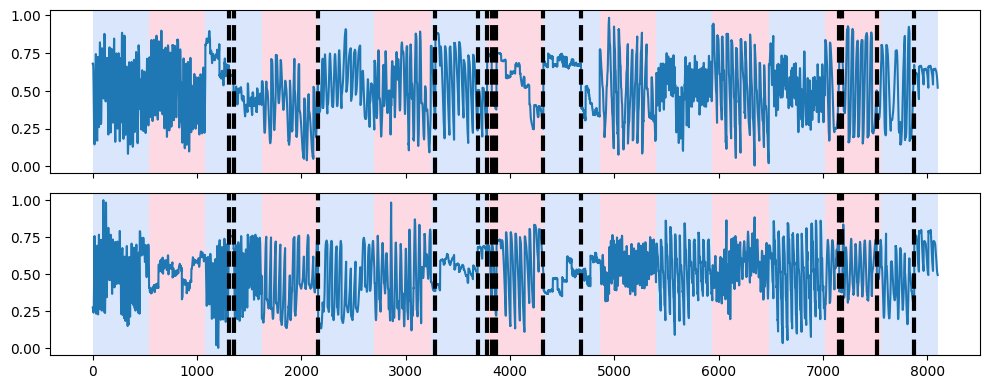

In [200]:
eval, result =  predict_change_points_window(libras_ds,n,original_points,"normal",window_size)
exp5[0] = eval.iloc[3,1]
eval

72.32142857142857


Metryka    Wartość
0     Acc   0.997370
1    Prec   0.428571
2  Recall   0.428571
3      F1   0.428571
4     ASC   0.428571
5     ASD  22.500000
6     ADT   0.500000

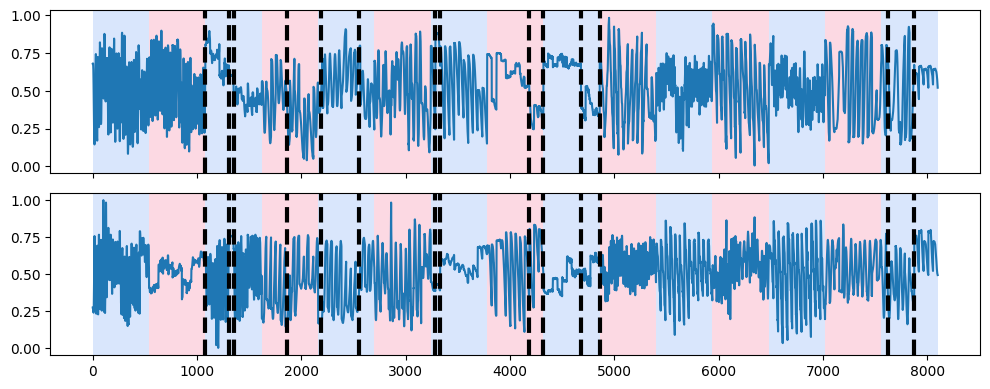

In [201]:
eval, result =  predict_change_points_binseg(libras_ds,n,original_points,"l1")
exp5[1] = eval.iloc[3,1]
eval

72.32142857142857


Metryka    Wartość
0     Acc   0.997042
1    Prec   0.357143
2  Recall   0.357143
3      F1   0.357143
4     ASC   0.428571
5     ASD  11.666667
6     ADT   0.166667

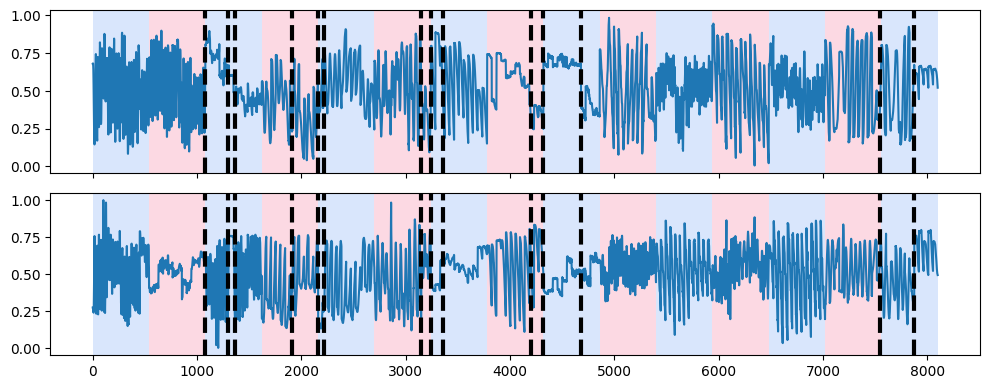

In [202]:
eval, result =  predict_change_points_bottomup(libras_ds,n,original_points,"l2")
exp5[2] = eval.iloc[3,1]
eval

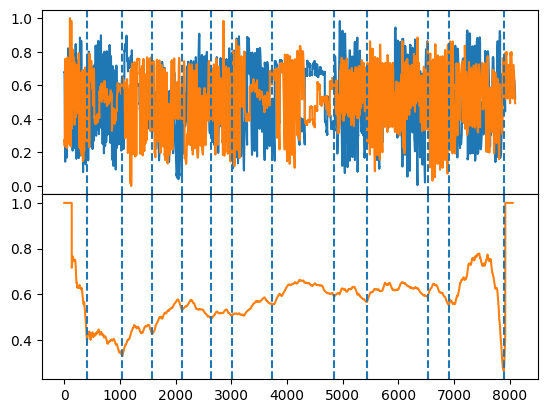

72.32142857142857
Conducted experimets: 5
window current average rank is: 3.0
binseg current average rank is: 3.2
bottomup current average rank is: 2.2
fluss current average rank is: 1.6


Metryka    Wartość
0     Acc   0.998356
1    Prec   0.666667
2  Recall   0.571429
3      F1   0.615385
4     ASC   0.571429
5     ASD  39.750000
6     ADT   0.250000

In [203]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(libras_ds)
FlussRegimeSegmentator.print_latest_output()

eval = get_evaluation(regimes,original_points,n)
exp5[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp5)
Benchmark.print_current_results()
eval

# Experiment 6 (Cricket)

In [8]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
# window_size = len(df.iloc[0,0][0])

# cricet_stacked, original_points = stack_time_series_randomly(df,False)
# cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)
# original_points = original_points.astype(dtype = int)

# cricket_ds = cricet_stacked_ndarray.astype(np.float64)
# rpt.display(cricket_ds, original_points)

# exp6 = np.zeros(Benchmark.algorithms_number)
# n = cricket_ds.shape[0]

                                         relationalAtt classAttribute
0    [[-0.97211, -0.95768, -0.95901, -0.95901, -0.9...         b'1.0'
1    [[-0.55916, -0.57613, -0.57443, -0.57953, -0.5...         b'1.0'
2    [[-0.78485, -0.78446, -0.7935, -0.79794, -0.80...         b'1.0'
3    [[-0.7008, -0.6821, -0.68397, -0.68397, -0.678...         b'1.0'
4    [[-0.79512, -0.7955, -0.79095, -0.78193, -0.78...         b'1.0'
..                                                 ...            ...
103  [[-0.7219, -0.70269, -0.69884, -0.6876, -0.687...        b'12.0'
104  [[-0.73562, -0.71582, -0.72344, -0.72922, -0.7...        b'12.0'
105  [[-0.57233, -0.55274, -0.56088, -0.56088, -0.5...        b'12.0'
106  [[-0.55444, -0.5644, -0.56011, -0.55381, -0.55...        b'12.0'
107  [[-0.72712, -0.72712, -0.72742, -0.72183, -0.7...        b'12.0'

[108 rows x 2 columns]


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka     Wartość
0     Acc    0.999835
1    Prec    0.272727
2  Recall    0.272727
3      F1    0.272727
4     ASC    0.272727
5     ASD  431.000000
6     ADT    0.333333

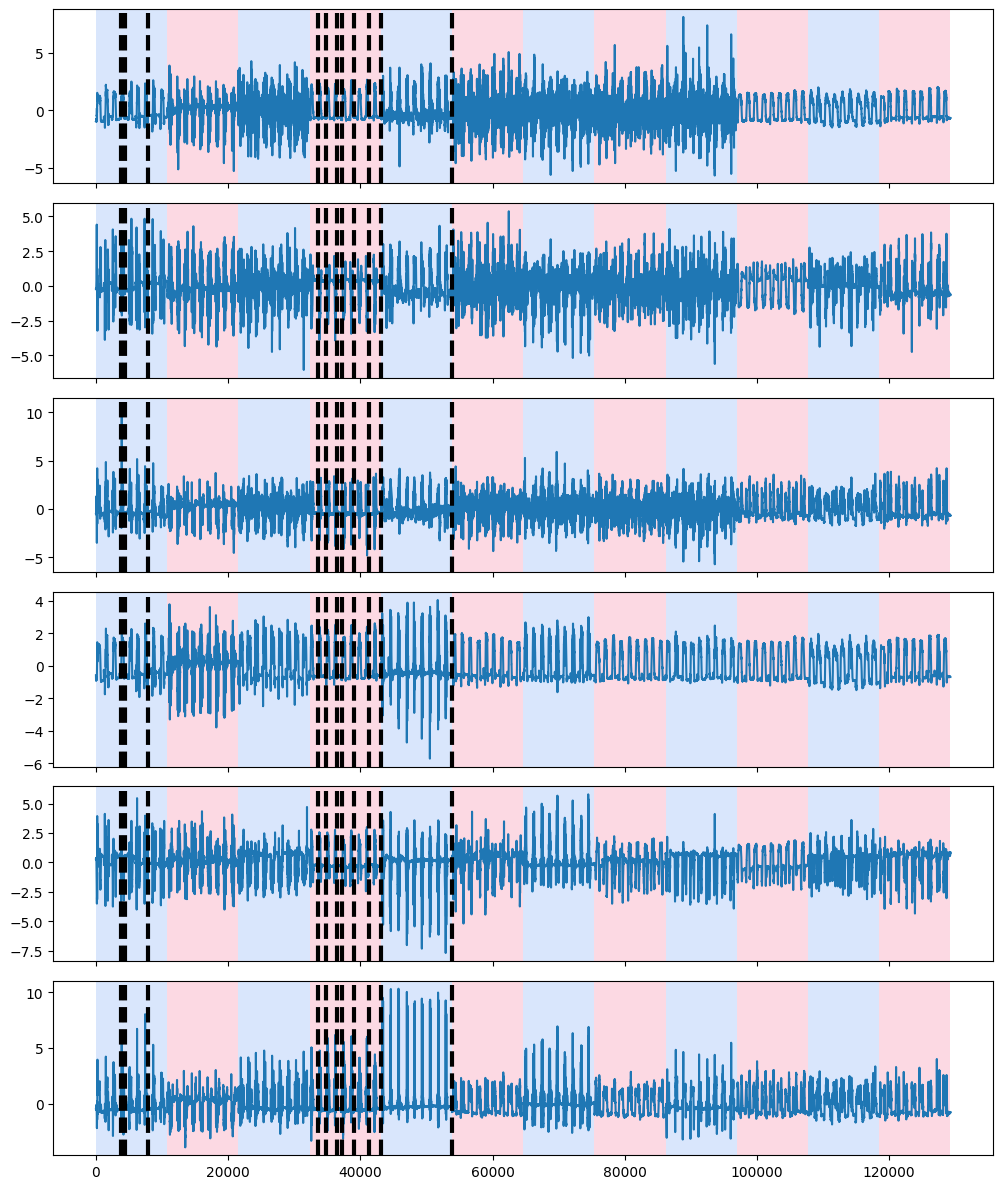

In [205]:
eval, result = predict_change_points_window(cricket_ds, n, original_points, "normal", window_size)
exp6[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  47.454545
6     ADT   0.636364

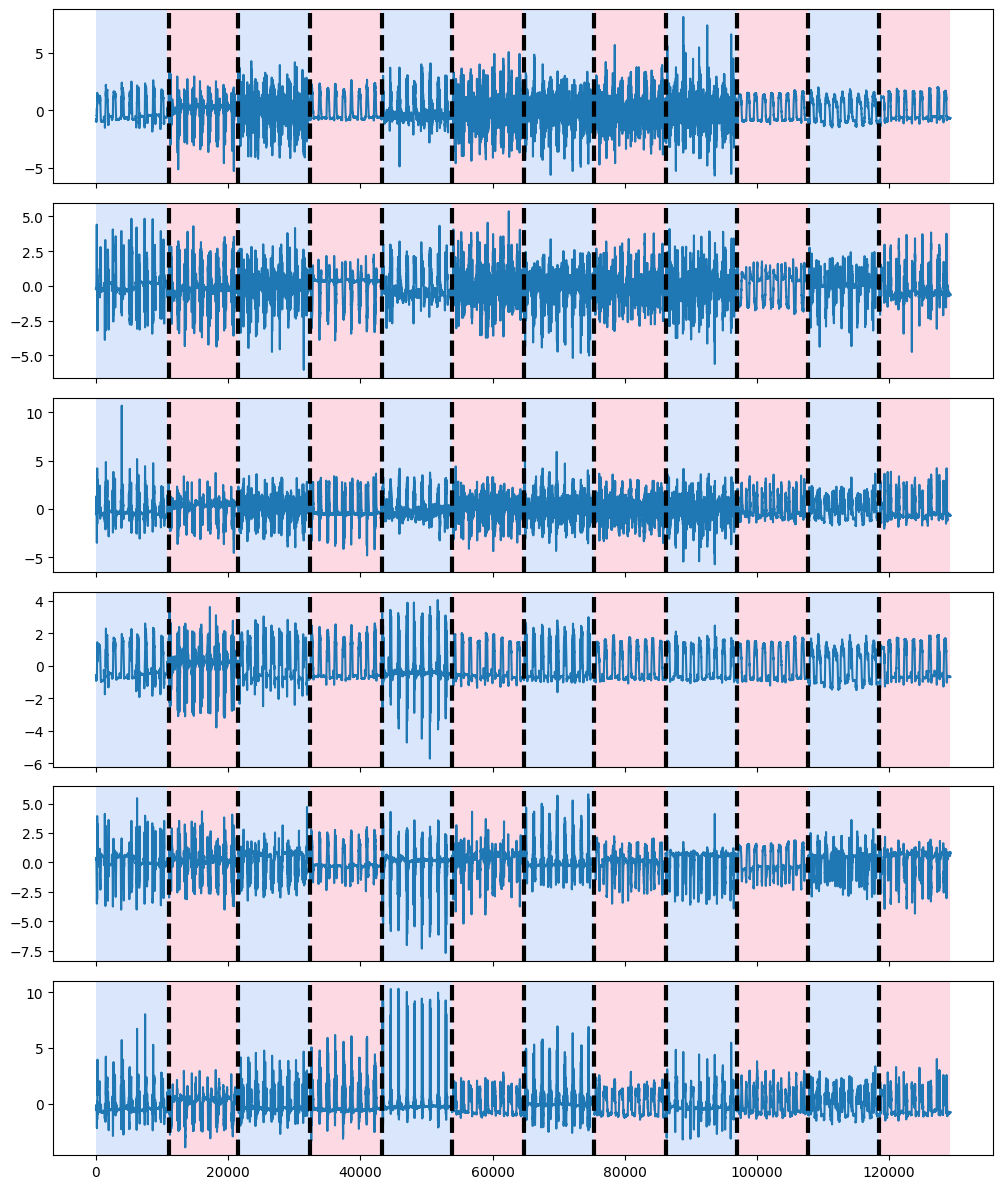

In [206]:
eval, result = predict_change_points_binseg(cricket_ds, n, original_points, "normal")
exp6[1] = eval.iloc[3,1]
eval



In [207]:
eval, result = predict_change_points_bottomup(cricket_ds, n, original_points, "normal")
exp6[2] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



1469.0454545454545


Metryka     Wartość
0     Acc    0.999938
1    Prec    0.727273
2  Recall    0.727273
3      F1    0.727273
4     ASC    0.727273
5     ASD  285.000000
6     ADT    0.375000

In [208]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(cricket_ds)
FlussRegimeSegmentator.print_latest_output()
eval = get_evaluation(regimes,original_points,n)

exp6[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp6)
Benchmark.print_current_results()
eval


1469.0454545454545
Conducted experimets: 6
window current average rank is: 3.1666666666666665
binseg current average rank is: 2.8333333333333335
bottomup current average rank is: 2.3333333333333335
fluss current average rank is: 1.6666666666666667


Metryka     Wartość
0     Acc    0.999979
1    Prec    0.909091
2  Recall    0.909091
3      F1    0.909091
4     ASC    0.909091
5     ASD  789.500000
6     ADT    0.000000

# Experiment 7 (SweadishLeafs 1)

In [9]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'
df = load_dataset_to_dataframe(filepath)
print(df)
swleaf_data, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp7 = np.zeros(Benchmark.algorithms_number)
rpt.display(swleaf_data, original_points)
n = swleaf_data.shape[0]

         att1     att2      att3      att4      att5      att6      att7  \
0    1.524750  1.53812  1.410790  1.244400  1.039470  0.868676  0.664257   
1    2.214930  2.05051  1.842350  1.635900  1.432590  1.285370  1.143260   
2    1.872010  1.72637  1.573640  1.396900  1.252210  1.083760  0.955383   
3    1.731019  1.70220  1.553009  1.387209  1.144580  0.951378  0.733035   
4    1.842670  1.74943  1.593560  1.420510  1.268400  1.118720  0.972792   
..        ...      ...       ...       ...       ...       ...       ...   
495  1.555160  1.39118  1.027670  0.747651  0.425793  0.158014  0.152089   
496  1.823961  1.74961  1.579271  1.384801  1.204190  1.022790  0.876355   
497  2.009910  1.89306  1.711190  1.492730  1.312480  1.097560  0.949675   
498  1.474660  1.49555  1.358110  1.142910  0.906578  0.752583  0.985894   
499  2.021830  1.92956  1.740330  1.581830  1.428630  1.250230  1.103560   

         att8      att9     att10  ...    att120    att121    att122  \
0    0.489801  

571.4285714285714


Metryka     Wartość
0     Acc    0.999583
1    Prec    0.285714
2  Recall    0.285714
3      F1    0.285714
4     ASC    0.285714
5     ASD  305.500000
6     ADT    0.500000

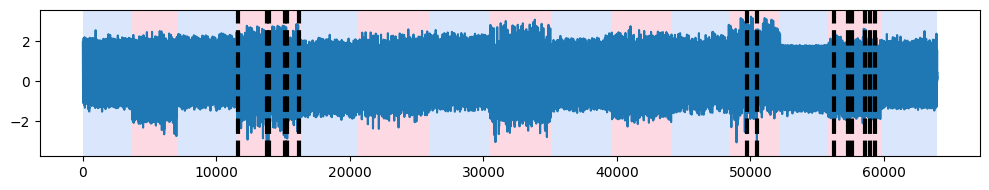

In [210]:
eval, result = predict_change_points_window(swleaf_data, n, original_points, "l2", window_size)
exp7[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



571.4285714285714


Metryka   Wartość
0     Acc  0.999417
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

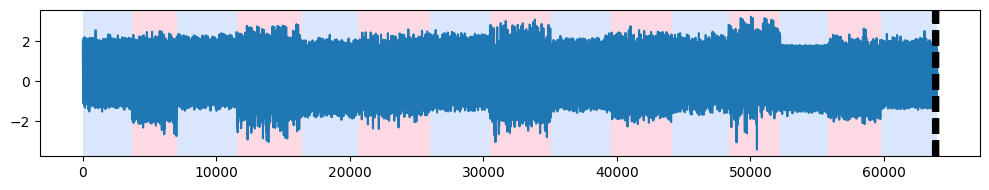

In [211]:
eval, result = predict_change_points_binseg(swleaf_data, n, original_points, "normal")
exp7[1] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



571.4285714285714


Metryka   Wartość
0     Acc  0.999417
1    Prec  0.000000
2  Recall  0.000000
3      F1  0.000000
4     ASC  0.000000
5     ASD -1.000000
6     ADT -1.000000

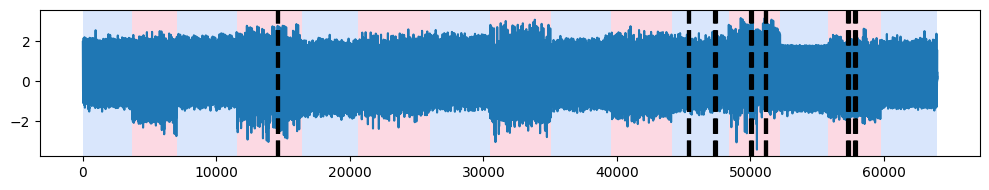

In [212]:
eval, result = predict_change_points_bottomup(swleaf_data, n, original_points, "normal")
exp7[2] = eval.iloc[3,1]
eval



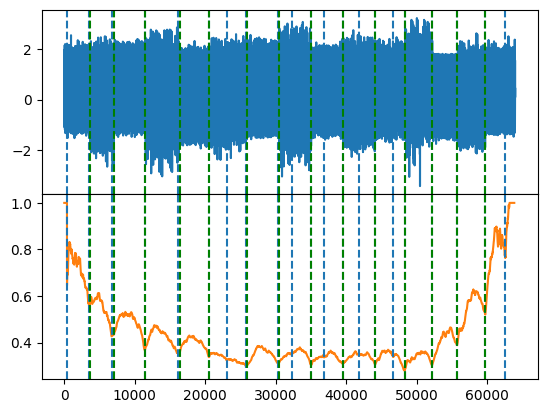

571.4285714285714
Conducted experimets: 7
window current average rank is: 3.0
binseg current average rank is: 3.0
bottomup current average rank is: 2.4285714285714284
fluss current average rank is: 1.5714285714285714


Metryka     Wartość
0     Acc    0.999854
1    Prec    0.666667
2  Recall    1.000000
3      F1    0.800000
4     ASC    1.000000
5     ASD  103.857143
6     ADT    0.000000

In [213]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(swleaf_data)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes, original_points, swleaf_data.shape[0])
exp7[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp7)
Benchmark.print_current_results()
eval

# Experiment 8 (sweadish leafs 2)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

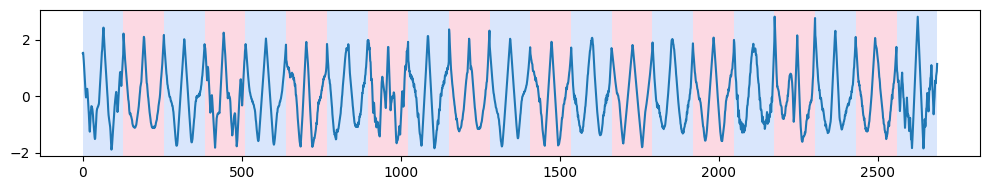

In [214]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

swleaf_data2, original_points, window_size = load_df_2d_representation(filepath)

x = 20 
i = original_points[x]
swleaf_data2 = swleaf_data2[:i]
original_points = original_points[:x+1]

exp8 = np.zeros(Benchmark.algorithms_number)
rpt.display(swleaf_data2,original_points)

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka   Wartość
0     Acc  0.984375
1    Prec  0.071429
2  Recall  0.050000
3      F1  0.058824
4     ASC  0.050000
5     ASD  4.000000
6     ADT  1.000000

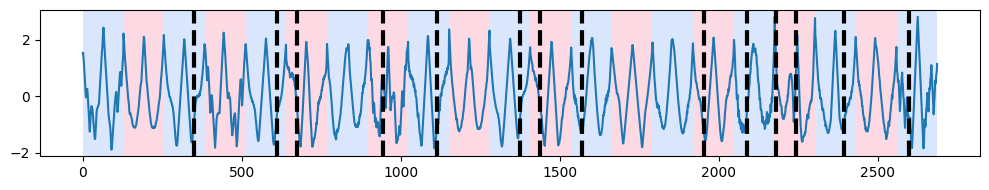

In [215]:
eval, result = predict_change_points_window(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal",window_size)
exp8[0] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka    Wartość
0     Acc   0.983407
1    Prec   0.150000
2  Recall   0.150000
3      F1   0.150000
4     ASC   0.200000
5     ASD  11.000000
6     ADT   0.250000

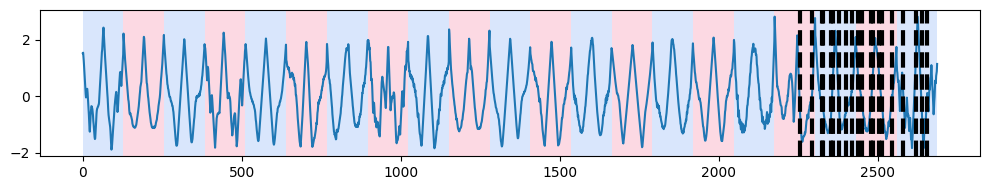

In [216]:
eval, result = predict_change_points_binseg(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal")
exp8[1] = eval.iloc[3,1]
eval



C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



16.8


Metryka   Wartość
0     Acc  0.981445
1    Prec  0.050000
2  Recall  0.050000
3      F1  0.050000
4     ASC  0.050000
5     ASD  6.000000
6     ADT  0.000000

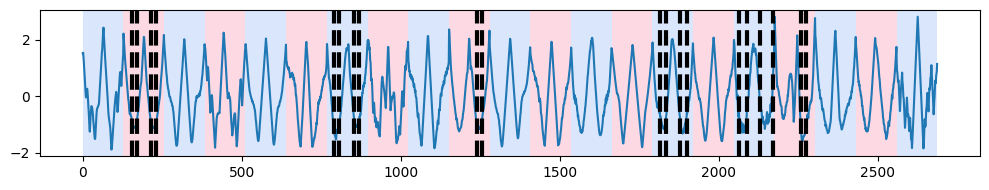

In [217]:
eval, result = predict_change_points_bottomup(swleaf_data2, swleaf_data2.shape[0], original_points[:-1], "normal")
exp8[2] = eval.iloc[3,1]
eval



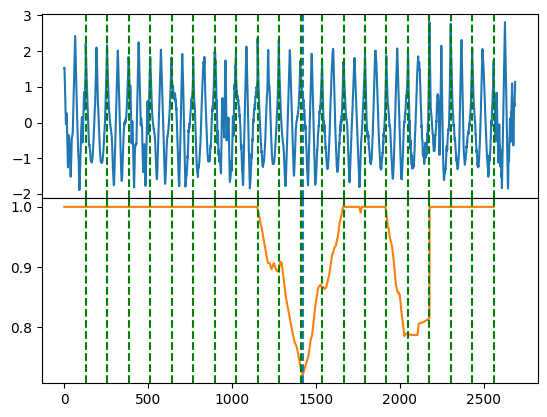

16.8
Conducted experimets: 8
window current average rank is: 3.0
binseg current average rank is: 2.75
bottomup current average rank is: 2.625
fluss current average rank is: 1.625


Metryka    Wartość
0     Acc   0.990723
1    Prec   1.000000
2  Recall   0.050000
3      F1   0.095238
4     ASC   0.050000
5     ASD  13.000000
6     ADT   1.000000

In [218]:
FlussRegimeSegmentator = Fluss(window_size,3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(swleaf_data2)
FlussRegimeSegmentator.print_latest_output(original_points[:-1])

eval = get_evaluation(regimes, original_points[:-1], swleaf_data2.shape[0])
exp8[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp8)
Benchmark.print_current_results()
eval

# Experiment 9 (basic_motions)

100
100


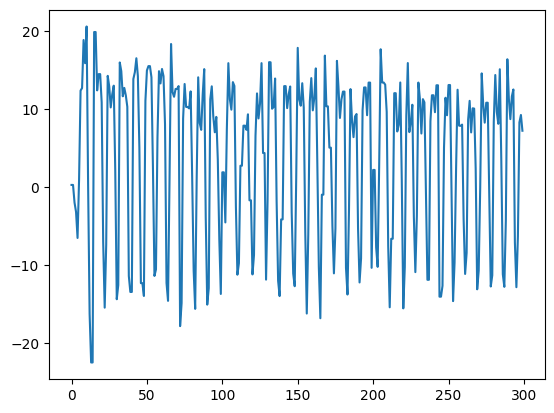

In [19]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))
window_size = len(df.iloc[0,0][0])

basic_ds, original_points = stack_time_series_randomly(df,False)
basic_ds = dataframe_to_ndarray(basic_ds)
original_points = original_points.astype(dtype = int)

basic_ds = basic_ds.astype(np.float64)


# exp9 = np.zeros(Benchmark.algorithms_number)
#rpt.display(basic_ds, original_points)
print(window_size)
# n = basic_ds.shape[0]
plt.plot(basic_ds[1000:1300,0])

166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  3.333333
6     ADT  0.666667

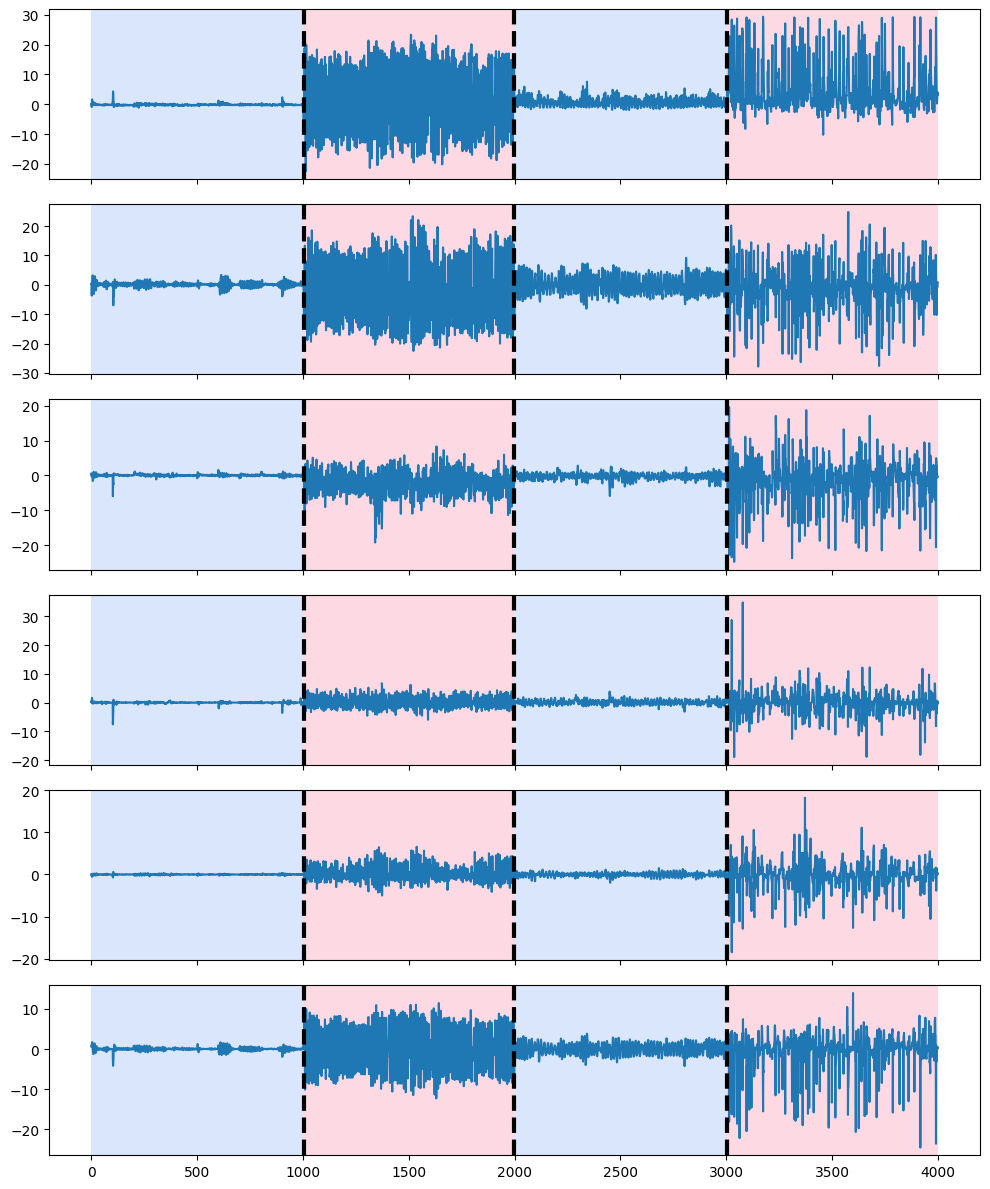

In [220]:
eval, result = predict_change_points_window(basic_ds, n, original_points, "l2", window_size)
exp9[0] = eval.iloc[3,1]
eval


166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  3.333333
6     ADT  0.666667

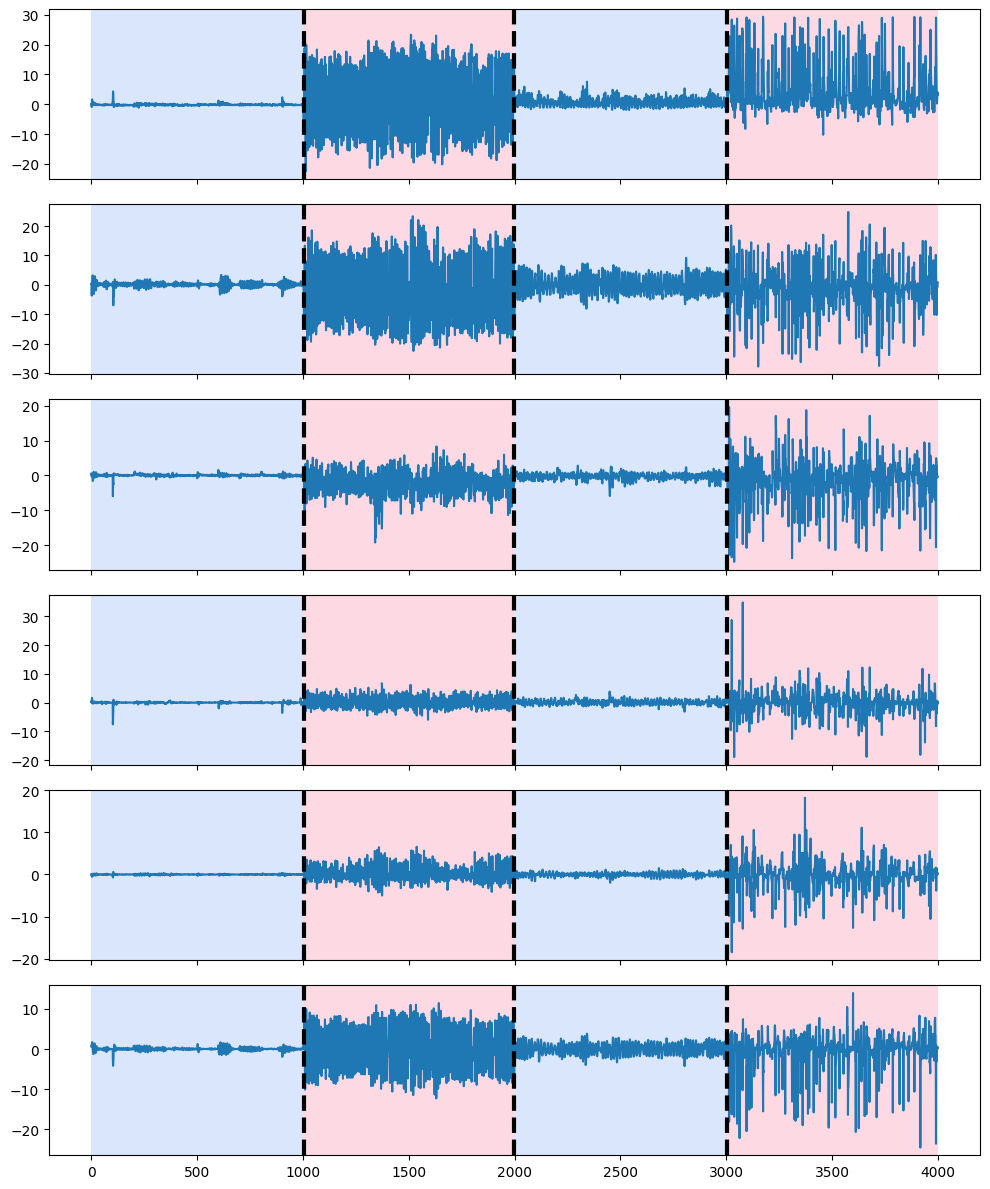

In [221]:
eval, result = predict_change_points_binseg(basic_ds, n, original_points, "l2")
exp9[1] = eval.iloc[3,1]
eval


166.66666666666666


Metryka   Wartość
0     Acc  1.000000
1    Prec  1.000000
2  Recall  1.000000
3      F1  1.000000
4     ASC  1.000000
5     ASD  6.666667
6     ADT  0.666667

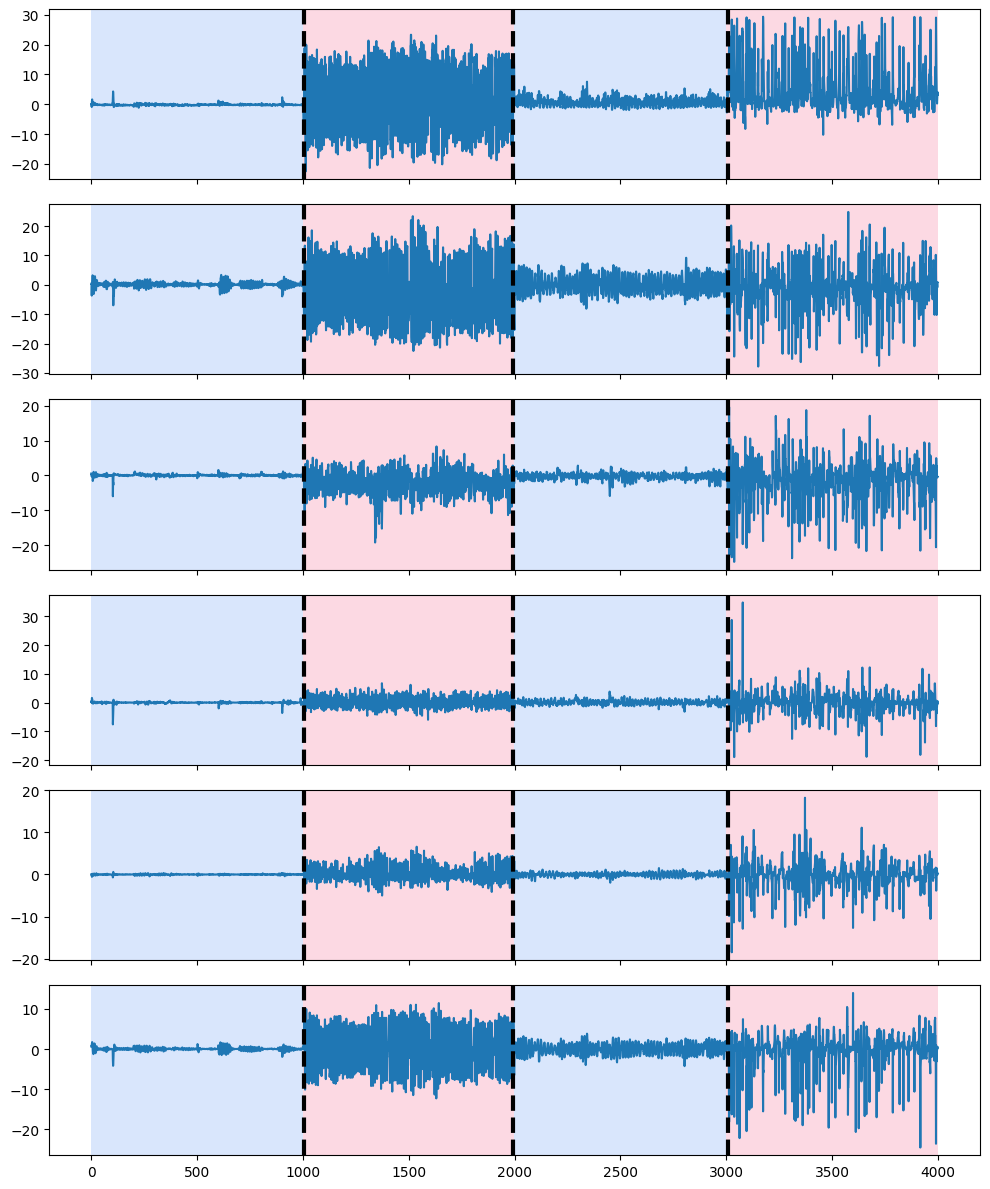

In [222]:
eval, result = predict_change_points_bottomup(basic_ds, n, original_points, "l2")
exp9[2] = eval.iloc[3,1]
eval


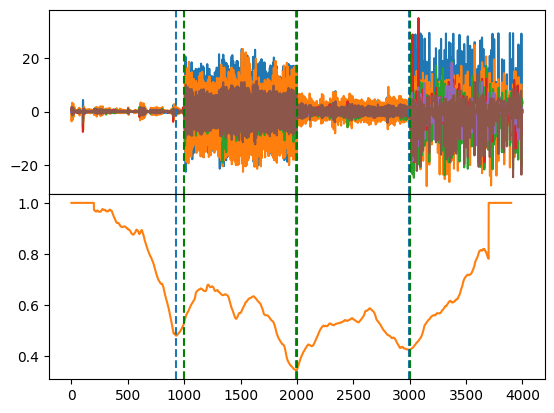

166.66666666666666
Conducted experimets: 9
window current average rank is: 3.111111111111111
binseg current average rank is: 2.7777777777777777
bottomup current average rank is: 2.5555555555555554
fluss current average rank is: 1.5555555555555556
[ 930 1995 2993]


Metryka    Wartość
0     Acc   1.000000
1    Prec   1.000000
2  Recall   1.000000
3      F1   1.000000
4     ASC   1.000000
5     ASD  27.333333
6     ADT   0.000000

In [223]:
FlussRegimeSegmentator = Fluss(window_size, 2)

cac, regimes = FlussRegimeSegmentator.m_predict_regimes(basic_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,n)
exp9[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp9)
Benchmark.print_current_results()
#rpt.display(racket_ds,change_points,regimes)
print(regimes)
eval

# Experiment 10 (BirdChicken)

In [224]:
filepath = './datasets/BirdChicken/BirdChicken_TRAIN.arff'

bc_ds, original_points, window_size = load_df_2d_representation_grouped(filepath)
exp10 = np.zeros(Benchmark.algorithms_number)
rpt.display(bc_ds, original_points)
n = bc_ds.shape[0]
# plt.show()
# plt.plot(beef_ds[:5*window_size])


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

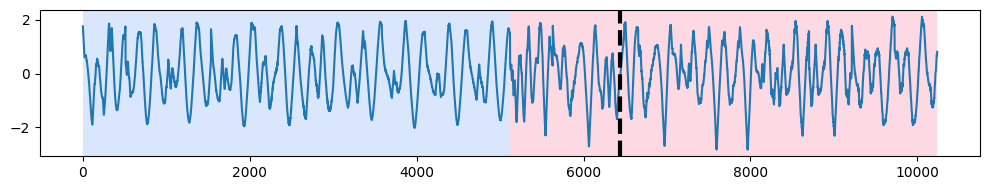

In [225]:
eval, result = predict_change_points_window(bc_ds, n, original_points, "rank",window_size)
exp10[0] = eval.iloc[3,1]
eval


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

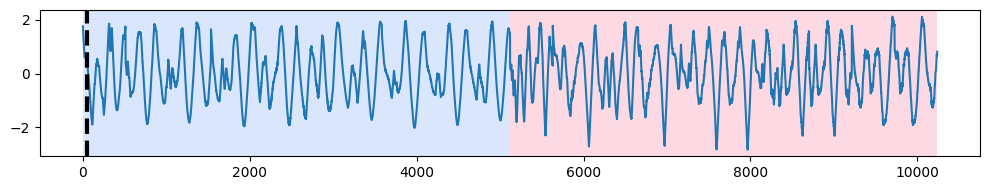

In [226]:
eval, result = predict_change_points_binseg(bc_ds, n, original_points, "l1")
exp10[1] = eval.iloc[3,1]
eval


In [227]:
eval, result = predict_change_points_bottomup(bc_ds, n, original_points, "l2")
exp10[2] = eval.iloc[3,1]
eval


1280.0


Metryka  Wartość
0     Acc  0.99974
1    Prec  0.00000
2  Recall  0.00000
3      F1  0.00000
4     ASC  0.00000
5     ASD -1.00000
6     ADT -1.00000

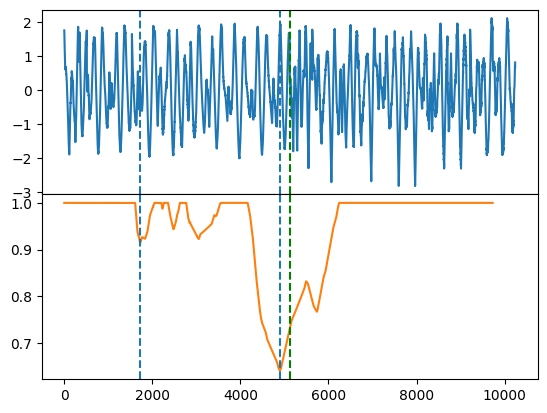

1280.0
Conducted experimets: 10
window current average rank is: 3.2
binseg current average rank is: 2.8
bottomup current average rank is: 2.5
fluss current average rank is: 1.5
[1728 4896]


Metryka     Wartość
0     Acc    0.999870
1    Prec    0.500000
2  Recall    1.000000
3      F1    0.666667
4     ASC    1.000000
5     ASD  224.000000
6     ADT    0.000000

In [228]:
FlussRegimeSegmentator = Fluss(window_size, 3)

cac, regimes = FlussRegimeSegmentator.predict_regimes(bc_ds)
FlussRegimeSegmentator.print_latest_output(original_points)

eval = get_evaluation(regimes,original_points,n)
exp10[3] = eval.iloc[3,1]
Benchmark.add_experiment(exp10)
#Benchmark.print_current_results()
#rpt.display(racket_ds,change_points,regimes)
print(regimes)
eval

# Benchmark Summary

In [ ]:
# import plotly.graph_objects as go

# import numpy as np
# np.random.seed(1)

# x = np.random.rand(100)
# y = np.random.rand(100)

# f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

# scatter = f.data[0]
# colors = ['#a3a7e4'] * 100
# scatter.marker.color = colors
# scatter.marker.size = [10] * 100
# f.layout.hovermode = 'closest'


# # create our callback function
# def update_point(trace, points, selector):
#     c = list(scatter.marker.color)
#     s = list(scatter.marker.size)
#     for i in points.point_inds:
#         c[i] = '#bae2be'
#         s[i] = 20
#         with f.batch_update():
#             scatter.marker.color = c
#             scatter.marker.size = s


# scatter.on_click(update_point)

# f

In [4]:
def experimentTemplate(isMultivariate, filepath, costW, costBS, costBU, seed, block_size, subset = 1.0, group = False):
    data = None
    n =  None
    window_size = None
    original_points = None

    
    if isMultivariate:
        data, original_points, window_size = load_data_multivariate_representation(filepath, seed, block_size)
        if subset != 1.0:
            size = len(original_points)
            index = round(size*subset)
            cut_index = original_points[index]
            data = data[:cut_index, :]
            original_points = original_points[:index]
        
    else:
        data, original_points, window_size = load_data_univariate_representation(filepath, seed, block_size, group)
        if subset != 1.0:
            size = len(original_points)
            index = round(size*subset)
            cut_index = original_points[index]
            data = data[:cut_index]
            original_points = original_points[:index]
            rpt.display(data, original_points)

    


    n = data.shape[0]
    
    all_evals = []
    eval, result = predict_change_points_window(data, n, original_points, costW, window_size)
    all_evals.append(eval)
    
    eval, result = predict_change_points_binseg(data, n, original_points, costBS)
    all_evals.append(eval)

    eval, result = predict_change_points_bottomup(data, n, original_points, costBU)
    all_evals.append(eval)
    
    FlussRegimeSegmentator = Fluss(window_size, 3)
    eval = None
    
    if(isMultivariate):
        cac, regimes = FlussRegimeSegmentator.m_predict_regimes(data)
        eval = get_evaluation(regimes, original_points, n)
        FlussRegimeSegmentator.print_latest_output()
        all_evals.append(eval)

    else:
        cac, regimes = FlussRegimeSegmentator.predict_regimes(data)
        eval = get_evaluation(regimes,original_points,n)
        all_evals.append(eval)
        

    return all_evals, data, original_points


# Experiment Registration 1

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

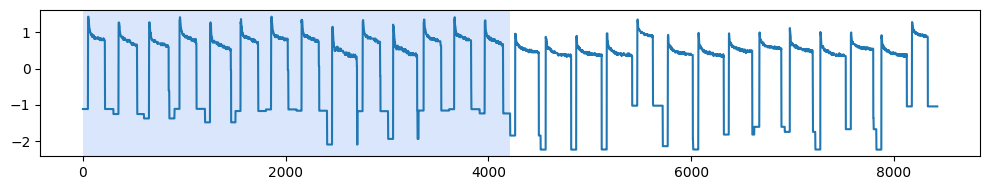

In [80]:
from BenchmarkCaller import *

BC = BenchmarkCaller()

filepath = './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'
data, original_points, window_size = load_data_univariate_representation(filepath, 6, 100, False, True)
rpt.display(data, original_points)

# data, original_points, window_size = load_data_univariate_representation(filepath, 45, 2000, True, True)
# rpt.display(data, original_points)

# BC.register_experiment(lambda seed, block_size : experimentTemplate(False, filepath,"l1" ,"l1" ,"l1" ,seed, block_size, 0.3,True))
# BC.call_experiments(42,1000) 

# Experiments

In [ ]:
BC = BenchmarkCaller()

filepath = './datasets/Libras/Libras_TRAIN.arff'
# data, original_points, window_size = load_data_multivariate_representation(filepath, 43, 10)
# rpt.display(data, original_points)

BC.register_experiment(lambda seed, block_size : experimentTemplate(True, filepath = './datasets/RacketSports/RacketSports_TRAIN.arff'
,"l1" ,"l1" ,"linear" ,seed, block_size,1.0))
BC.register_experiment(lambda seed, block_size : experimentTemplate(True, filepath,"l1" ,"l1" ,"linear" ,seed, block_size,1.0))

BC.call_experiments(42,30)

In [43]:
print(np.random.permutation(len([1,3,4,5,6,7,8])))

[6 5 3 2 0 4 1]
